Training and comparing results of PHSI, SINDy and BSI models on tank system with four tanks and five pipes.  

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
#import from phlearn
from phlearn.phnns import R_estimator, ExternalForcesNN
from phlearn.phnns import npoints_to_ntrajectories_tsample

#import from phsi
from phsi.phsystems import init_tanksystem
from phsi.phnns import PHSI, BaselineSI, generate_dataset, train
ttype = torch.float32
torch.set_default_dtype(ttype)

In [3]:
#set up parameters for tank system
ntrainingpoints = 3000
sampling_time = 1/100
t_max = 0.5
integrator = 'srk4'
F_timedependent = False
F_statedependent = True
hidden_dim = 100
learning_rate = 3e-2
batch_size = 32
epochs = 100
l1_param_forces = 0.001
l1_param_dissipation = 0.
l1_val_params = 0.5
prune_interval = 10
shuffle = True
noise_std = 0.0
seed = 1
verbose = True
ntrajectories_val = 0

In [4]:
#set up tank system
ntrajectories_train, t_sample = npoints_to_ntrajectories_tsample(ntrainingpoints, t_max, sampling_time)

pH_system = init_tanksystem()
damped_states = np.arange(pH_system.nstates) < pH_system.npipes

pH_system.seed(seed)
nstates = pH_system.nstates

In [5]:
#create nosieless dataset
traindata = generate_dataset(pH_system, integrator, ntrajectories_train, t_sample, nsamples=ntrainingpoints, noise_std=noise_std)
valdata = generate_dataset(pH_system, integrator, ntrajectories_val, t_sample, noise_std=noise_std)

#create noisy dataset
noise_std = 0.005
traindata_noise = generate_dataset(pH_system, integrator, ntrajectories_train, t_sample, nsamples=ntrainingpoints, noise_std=noise_std)
valdata_noise = generate_dataset(pH_system, integrator, ntrajectories_val, t_sample, noise_std=noise_std)

In [6]:
#setup PHSI model
function_space = np.array([1,0])   #first argument is polynomial terms, the second is trigonometric terms
external_forces_filter = np.zeros(nstates); external_forces_filter[-1] = 1
ext_forces_nn = ExternalForcesNN(nstates, 1, hidden_dim=hidden_dim,
                                            timedependent=F_timedependent,
                                            statedependent=F_statedependent,
                                            external_forces_filter=external_forces_filter)
R_estimator = R_estimator(damped_states)
model_phsi = PHSI(nstates, pH_system.structure_matrix, function_space, \
                 ext_forces_nn, R_estimator, degrees=2, full_si=False)
model_phsi_noise = PHSI(nstates, pH_system.structure_matrix, function_space, \
                 ext_forces_nn, R_estimator, degrees=2, full_si=False)

optimizer_phsi = torch.optim.Adam(model_phsi.parameters(), lr=learning_rate, weight_decay=1e-4)
optimizer_phsi_noise = torch.optim.Adam(model_phsi_noise.parameters(), lr=learning_rate, weight_decay=1e-4)

In [7]:
#train PHSI model
phsi, vloss = train(model_phsi, integrator, traindata, optimizer_phsi, valdata=valdata, epochs=epochs,
                  batch_size=batch_size, shuffle=shuffle, l1_param_forces=l1_param_forces,
                  l1_param_dissipation=l1_param_dissipation, l1_val_params=l1_val_params, prune_val=prune_interval,
                  loss_fn=torch.nn.MSELoss(), verbose=verbose,
                  return_best=True)

/Users/Sigurd/opt/anaconda3/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



Epoch 0
Training loss: 2.46e+02
Epoch training time: 7.75 seconds
x^[1 0 0 0 0 0 0 0 0]: 0.0020, x^[2 0 0 0 0 0 0 0 0]: 2.7823, x^[1 1 0 0 0 0 0 0 0]: 2.6701, x^[1 0 1 0 0 0 0 0 0]: 2.5415, x^[1 0 0 1 0 0 0 0 0]:-1.1063, 
x^[1 0 0 0 1 0 0 0 0]:-0.1245, x^[1 0 0 0 0 1 0 0 0]: 0.0153, x^[1 0 0 0 0 0 1 0 0]: 0.0009, x^[1 0 0 0 0 0 0 1 0]: 0.0036, x^[1 0 0 0 0 0 0 0 1]:-0.1017, 
x^[0 1 0 0 0 0 0 0 0]: 0.0159, x^[0 2 0 0 0 0 0 0 0]: 2.7477, x^[0 1 1 0 0 0 0 0 0]: 2.4443, x^[0 1 0 1 0 0 0 0 0]: 2.7270, x^[0 1 0 0 1 0 0 0 0]:-2.2565, 
x^[0 1 0 0 0 1 0 0 0]: 0.0741, x^[0 1 0 0 0 0 1 0 0]:-0.0328, x^[0 1 0 0 0 0 0 1 0]: 0.0127, x^[0 1 0 0 0 0 0 0 1]: 0.0135, x^[0 0 1 0 0 0 0 0 0]: 0.0164, 
x^[0 0 2 0 0 0 0 0 0]: 2.1542, x^[0 0 1 1 0 0 0 0 0]: 0.2906, x^[0 0 1 0 1 0 0 0 0]:-0.1458, x^[0 0 1 0 0 1 0 0 0]: 0.1322, x^[0 0 1 0 0 0 1 0 0]:-0.0001, 
x^[0 0 1 0 0 0 0 1 0]: 0.0027, x^[0 0 1 0 0 0 0 0 1]:-0.6719, x^[0 0 0 1 0 0 0 0 0]: 0.0946, x^[0 0 0 2 0 0 0 0 0]: 2.6845, x^[0 0 0 1 1 0 0 0 0]:-2.0688

In [8]:
#train PHSI model on noisy data
phsi_noise, vloss = train(model_phsi_noise, integrator, traindata_noise, optimizer_phsi_noise, valdata=valdata_noise, epochs=epochs,
                  batch_size=batch_size, shuffle=shuffle, l1_param_forces=l1_param_forces,
                  l1_param_dissipation=l1_param_dissipation, l1_val_params=l1_val_params, prune_val=prune_interval,
                  loss_fn=torch.nn.MSELoss(), verbose=verbose, return_best=True)


Epoch 0
Training loss: 2.14e+02
Epoch training time: 7.47 seconds
x^[1 0 0 0 0 0 0 0 0]: 0.0304, x^[2 0 0 0 0 0 0 0 0]: 2.7374, x^[1 1 0 0 0 0 0 0 0]: 2.1372, x^[1 0 1 0 0 0 0 0 0]: 2.5492, x^[1 0 0 1 0 0 0 0 0]:-1.9480, 
x^[1 0 0 0 1 0 0 0 0]: 0.0563, x^[1 0 0 0 0 1 0 0 0]: 0.1542, x^[1 0 0 0 0 0 1 0 0]: 0.0292, x^[1 0 0 0 0 0 0 1 0]: 0.0062, x^[1 0 0 0 0 0 0 0 1]:-0.0368, 
x^[0 1 0 0 0 0 0 0 0]: 0.0105, x^[0 2 0 0 0 0 0 0 0]: 2.5516, x^[0 1 1 0 0 0 0 0 0]: 2.3577, x^[0 1 0 1 0 0 0 0 0]: 2.3918, x^[0 1 0 0 1 0 0 0 0]:-1.8616, 
x^[0 1 0 0 0 1 0 0 0]:-0.0367, x^[0 1 0 0 0 0 1 0 0]:-0.0061, x^[0 1 0 0 0 0 0 1 0]:-0.0854, x^[0 1 0 0 0 0 0 0 1]: 0.0281, x^[0 0 1 0 0 0 0 0 0]:-0.0002, 
x^[0 0 2 0 0 0 0 0 0]: 2.2803, x^[0 0 1 1 0 0 0 0 0]:-0.0158, x^[0 0 1 0 1 0 0 0 0]:-0.0013, x^[0 0 1 0 0 1 0 0 0]: 0.0044, x^[0 0 1 0 0 0 1 0 0]: 0.0028, 
x^[0 0 1 0 0 0 0 1 0]: 0.0107, x^[0 0 1 0 0 0 0 0 1]:-0.5321, x^[0 0 0 1 0 0 0 0 0]:-0.0122, x^[0 0 0 2 0 0 0 0 0]: 2.6715, x^[0 0 0 1 1 0 0 0 0]:-1.7945

In [9]:
#setup BSI
pol_space = True
trig_space = False
time_pol_space = False
time_trig_space = False
model_baseline = BaselineSI(nstates, degrees=1, pol_space=pol_space,\
    trig_space=trig_space, time_pol_space=time_pol_space, time_trig_space=time_trig_space)
model_baseline_noise = BaselineSI(nstates, degrees=1, pol_space=pol_space,\
    trig_space=trig_space, time_trig_space=time_trig_space, time_pol_space=time_pol_space)

optimizer_baseline = torch.optim.Adam(model_baseline.parameters(), lr=learning_rate, weight_decay=1e-4)
optimizer_baseline_noise = torch.optim.Adam(model_baseline_noise.parameters(), lr=learning_rate, weight_decay=1e-4)

In [10]:
#train BSI model
baselinesi, vloss = train(model_baseline, integrator, traindata, optimizer_baseline, valdata=valdata, epochs=epochs,
                  batch_size=batch_size, shuffle=shuffle, l1_val_params=l1_val_params, prune_val=prune_interval,
                  loss_fn=torch.nn.MSELoss(), verbose=verbose, return_best=True)


Epoch 0
Training loss: 3.18e+02
Epoch training time: 1.1 seconds
x1': x^[0, 0, 0, 0, 0, 0, 0, 0, 0]: 0.1558, x^[1 0 0 0 0 0 0 0 0]:-0.8677, x^[0 1 0 0 0 0 0 0 0]: 0.1427, x^[0 0 1 0 0 0 0 0 0]: 1.2243, 
x^[0 0 0 1 0 0 0 0 0]:-0.0414, x^[0 0 0 0 1 0 0 0 0]: 1.0547, x^[0 0 0 0 0 1 0 0 0]:-2.3547, x^[0 0 0 0 0 0 1 0 0]: 2.8031, x^[0 0 0 0 0 0 0 1 0]: 1.5713, 
x^[0 0 0 0 0 0 0 0 1]: 0.8812, 

x2': x^[0, 0, 0, 0, 0, 0, 0, 0, 0]: 0.2239, x^[1 0 0 0 0 0 0 0 0]:-0.0282, x^[0 1 0 0 0 0 0 0 0]:-0.6142, x^[0 0 1 0 0 0 0 0 0]: 1.0752, 
x^[0 0 0 1 0 0 0 0 0]: 0.0298, x^[0 0 0 0 1 0 0 0 0]: 0.2317, x^[0 0 0 0 0 1 0 0 0]:-2.3368, x^[0 0 0 0 0 0 1 0 0]:-0.1859, x^[0 0 0 0 0 0 0 1 0]: 2.8098, 
x^[0 0 0 0 0 0 0 0 1]:-0.1787, 

x3': x^[0, 0, 0, 0, 0, 0, 0, 0, 0]:-0.0793, x^[1 0 0 0 0 0 0 0 0]:-0.5375, x^[0 1 0 0 0 0 0 0 0]:-0.4741, x^[0 0 1 0 0 0 0 0 0]:-1.1816, 
x^[0 0 0 1 0 0 0 0 0]: 0.7776, x^[0 0 0 0 1 0 0 0 0]: 0.7374, x^[0 0 0 0 0 1 0 0 0]:-2.3298, x^[0 0 0 0 0 0 1 0 0]: 0.7646, x^[0 0 0 0 0 0 0 1

In [11]:
#train BSI model on noisy data
baselinesi_noise, vloss = train(model_baseline_noise, integrator, traindata_noise, optimizer_baseline_noise, valdata=valdata_noise, epochs=epochs,
                  batch_size=batch_size, shuffle=shuffle, l1_param_forces=l1_param_forces,
                  l1_param_dissipation=l1_param_dissipation, l1_val_params=l1_val_params, prune_val=prune_interval,
                  loss_fn=torch.nn.MSELoss(), verbose=verbose, return_best=True)


Epoch 0
Training loss: 2.81e+02
Epoch training time: 0.96 seconds
x1': x^[0, 0, 0, 0, 0, 0, 0, 0, 0]: 0.2550, x^[1 0 0 0 0 0 0 0 0]:-1.1138, x^[0 1 0 0 0 0 0 0 0]: 0.9592, x^[0 0 1 0 0 0 0 0 0]: 1.1296, 
x^[0 0 0 1 0 0 0 0 0]: 0.0230, x^[0 0 0 0 1 0 0 0 0]: 0.6024, x^[0 0 0 0 0 1 0 0 0]:-2.3597, x^[0 0 0 0 0 0 1 0 0]: 2.7980, x^[0 0 0 0 0 0 0 1 0]: 0.0718, 
x^[0 0 0 0 0 0 0 0 1]: 0.8740, 

x2': x^[0, 0, 0, 0, 0, 0, 0, 0, 0]:-0.1292, x^[1 0 0 0 0 0 0 0 0]:-0.1631, x^[0 1 0 0 0 0 0 0 0]:-0.6878, x^[0 0 1 0 0 0 0 0 0]: 0.2500, 
x^[0 0 0 1 0 0 0 0 0]: 0.5835, x^[0 0 0 0 1 0 0 0 0]:-0.3698, x^[0 0 0 0 0 1 0 0 0]:-2.3719, x^[0 0 0 0 0 0 1 0 0]: 0.0522, x^[0 0 0 0 0 0 0 1 0]: 2.6880, 
x^[0 0 0 0 0 0 0 0 1]: 0.2971, 

x3': x^[0, 0, 0, 0, 0, 0, 0, 0, 0]: 0.1707, x^[1 0 0 0 0 0 0 0 0]:-0.9998, x^[0 1 0 0 0 0 0 0 0]: 0.1535, x^[0 0 1 0 0 0 0 0 0]:-1.0712, 
x^[0 0 0 1 0 0 0 0 0]: 1.0056, x^[0 0 0 0 1 0 0 0 0]:-0.4245, x^[0 0 0 0 0 1 0 0 0]:-2.3468, x^[0 0 0 0 0 0 1 0 0]: 0.9711, x^[0 0 0 0 0 0 0 

In [12]:
#SINDy setup
import pysindy as ps
from pysindy.feature_library.polynomial_library import PolynomialLibrary

x_vals = []
batch = round(t_max / sampling_time)
for i in range(ntrajectories_train):
    x_vals.append(np.array(traindata[0][0][i*batch:(i+1)*batch]))

x_vals_noise = []
batch = round(t_max / sampling_time)
for i in range(ntrajectories_train):
    x_vals_noise.append(np.array(traindata_noise[0][0][i*batch:(i+1)*batch]))



In [20]:
#train SINDy
sindy_optm = ps.SR3(threshold=0.5, nu=1.0, max_iter=100)
sindy_library = PolynomialLibrary(degree=2, include_interaction=True)
sindy = ps.SINDy(optimizer = sindy_optm, feature_library=sindy_library, discrete_time=False, \
    feature_names=["x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8", "x9"])
sindy.fit(x_vals, t=0.01, multiple_trajectories=True)
sindy.print()

(x1)' = -1.472 x1 + -9.500 x6 + 9.596 x7
(x2)' = -1.461 x2 + -9.503 x6 + 9.510 x8
(x3)' = -4.435 x3 + -9.507 x6 + 9.593 x9
(x4)' = -2.443 x4 + -9.595 x7 + 9.497 x8
(x5)' = -2.435 x5 + -9.497 x8 + 9.586 x9
(x6)' = 48.709 x1 + 48.718 x2 + 48.747 x3
(x7)' = -48.962 x1 + 48.969 x4
(x8)' = -48.718 x2 + -48.747 x4 + 48.670 x5 + 0.342 x3 x5
(x9)' = 0.537 x1 + -48.977 x3 + -0.628 x4 + -48.978 x5 + -3.637 x9 + 0.228 x1 x5 + -0.404 x1 x9 + 0.371 x2 x3 + 0.582 x3 x4


In [18]:
#train SINDy on noisy data
sindy_optm_noise = ps.SR3(threshold=0.5, nu=1.0, max_iter=100)
sindy_library = PolynomialLibrary(degree=2, include_interaction=True)
sindy_noise = ps.SINDy(optimizer = sindy_optm_noise, feature_library=sindy_library, discrete_time=False, \
    feature_names=["x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8", "x9"])
sindy_noise.fit(x_vals_noise, t=0.01, multiple_trajectories=True)
sindy_noise.print()

(x1)' = -1.496 x1 + -9.498 x6 + 9.587 x7
(x2)' = -1.442 x2 + -9.510 x6 + 9.509 x8
(x3)' = -4.444 x3 + -9.496 x6 + 9.586 x9
(x4)' = -2.462 x4 + -9.571 x7 + 9.496 x8
(x5)' = -2.478 x5 + -9.502 x8 + 9.568 x9
(x6)' = 48.658 x1 + 48.670 x2 + 48.764 x3 + 0.529 x1 x4
(x7)' = -49.028 x1 + 48.973 x4 + -0.367 x1 x4
(x8)' = -48.674 x2 + -48.689 x4 + 48.740 x5 + 0.536 x3 x4 + -0.507 x3 x5
(x9)' = -48.688 x3 + -0.713 x4 + -49.207 x5 + -3.563 x9 + 0.688 x1 x9 + -0.444 x2 x3 + -0.849 x3 x4 + -0.418 x4 x9


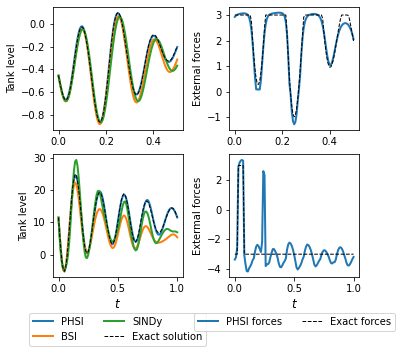

In [15]:
#trajectory over time om noisy data
def init_sampler(rng):              #sample extrpolated data
    rng = np.random.default_rng(seed)
    return rng.uniform(low=1, high=20, size=pH_system.nstates)

tank_sim = init_tanksystem(init_sampler=init_sampler)
tank_sim.seed(seed)

#simulate data
t_sim = np.linspace(0, 0.5, 101)
x_exact, dxdt, _, _ = pH_system.sample_trajectory(t_sim)
x0 = x_exact[0, :]
nsamples = t_sim.shape[0]
x_phsi, _ = phsi_noise.simulate_trajectory(integrator=False, t_sample=t_sim, x0=x0)
x_baseline, _ = baselinesi_noise.simulate_trajectory(integrator=False, t_sample=t_sim, x0=x0)
x_sindy = sindy_noise.simulate(x0, t_sim)

F_phsi = phsi_noise.external_forces(torch.tensor(x_phsi, dtype=ttype),
        torch.tensor(t_sim.reshape(nsamples, 1), dtype=ttype)).detach().numpy()
F_exact = pH_system.external_forces(x_exact, t_sim)

#simulate extrapolated data
t_sim_ex = np.linspace(0, 1, 101)
x_exact_ex, dxdt, _, _ = tank_sim.sample_trajectory(t_sim_ex)
x0_ex = x_exact_ex[0, :]
x_phsi_ex, _ = phsi_noise.simulate_trajectory(integrator=False, t_sample=t_sim_ex, x0=x0_ex)
x_baseline_ex, _ = baselinesi_noise.simulate_trajectory(integrator=False, t_sample=t_sim_ex, x0=x0_ex)
x_sindy_ex = sindy_noise.simulate(x0_ex, t_sim_ex)

F_phsi_ex = phsi_noise.external_forces(torch.tensor(x_phsi_ex, dtype=ttype),
        torch.tensor(t_sim.reshape(nsamples, 1), dtype=ttype)).detach().numpy()
F_exact_ex = tank_sim.external_forces(x_exact_ex, t_sim_ex)

fig, ax = plt.subplots(2,2)
fig.set_size_inches(5.5,5)
tank=8
ax[0,0].plot(t_sim, x_phsi[:, tank], linewidth=2, label='PHSI')
ax[0,0].plot(t_sim, x_baseline[:, tank], linewidth=2, label='BSI')
ax[0,0].plot(t_sim, x_sindy[:, tank], linewidth=2, label='SINDy')
ax[0,0].plot(t_sim, x_exact[:, tank], 'k--', linewidth=1, label='Exact solution')
ax[0,1].plot(t_sim, F_phsi[:, -1], linewidth=2, label='PHSI forces')
ax[0,1].plot(t_sim, F_exact[:, -1], 'k--', linewidth=1, label='Exact forces')

ax[1,0].plot(t_sim_ex, x_phsi_ex[:, tank], linewidth=2, label='PHSI')
ax[1,0].plot(t_sim_ex, x_baseline_ex[:, tank], linewidth=2, label='BSI')
ax[1,0].plot(t_sim_ex, x_sindy_ex[:, tank], linewidth=2, label='SINDy')
ax[1,0].plot(t_sim_ex, x_exact_ex[:, tank], 'k--', linewidth=1, label='Exact solution')
ax[1,1].plot(t_sim_ex, F_phsi_ex[:, -1], linewidth=2, label='PHSI forces')
ax[1,1].plot(t_sim_ex, F_exact_ex[:, -1], 'k--', linewidth=1, label='Exact forces')
ax[1,0].set_xlabel('$t$', fontsize=12)
ax[1,1].set_xlabel('$t$', fontsize=12)
ax[0,0].set_ylabel('Tank level'); ax[1,0].set_ylabel('Tank level')
ax[0,1].set_ylabel('External forces'); ax[1,1].set_ylabel('Extermal forces')
ax[1,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25),
    fancybox=True, ncol=2)
ax[1,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25),
    fancybox=True, ncol=2)
fig.subplots_adjust(bottom = 0.2, top=0.95, wspace=0.35)
plt.savefig('plots/tank/tank_trajectory_extr_noise.pdf')

1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


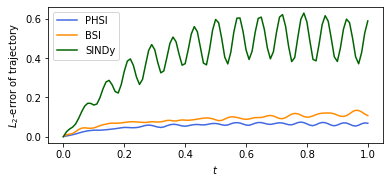

In [16]:
#error plot over time on noisy data
t_sim = np.linspace(0, 1, 101)
c_phsi = 'royalblue'; c_sindy = 'darkgreen'; c_baseline = 'darkorange'

nruns = 10
sum_l2_phsi=np.zeros(101)
sum_l2_baselinesi=np.zeros(101)
sum_l2_sindy=np.zeros(101)
for i in range(nruns):
    x_exact, dxdt, _, _ = pH_system.sample_trajectory(t_sim)
    x0 = x_exact[0, :]
    nsamples = t_sim.shape[0]
    x_phsi_noise, _ = phsi_noise.simulate_trajectory(integrator=False, t_sample=t_sim, x0=x0)
    x_baselinesi_noise, _ = baselinesi_noise.simulate_trajectory(integrator=False, t_sample=t_sim, x0=x0)
    x_sindy_noise = sindy_noise.simulate(x0, t_sim)

    sum_l2_phsi += np.sqrt(np.sum((x_exact - x_phsi_noise)**2, axis=1))
    sum_l2_baselinesi += np.sqrt(np.sum((x_exact - x_baselinesi_noise)**2, axis=1))
    sum_l2_sindy += np.sqrt(np.sum((x_exact - x_sindy_noise)**2, axis=1))
    print(f"{i+1} / {nruns}")

fig, ax = plt.subplots()
fig.set_size_inches(6, 2.5)
ax.plot(t_sim, sum_l2_phsi/nruns, label='PHSI', color=c_phsi)
ax.plot(t_sim, sum_l2_baselinesi/nruns, label='BSI', color=c_baseline)
ax.plot(t_sim, sum_l2_sindy/nruns, label='SINDy', color=c_sindy)
ax.set_ylabel('$L_2$-error of trajectory')
ax.set_xlabel('$t$')
ax.legend()
plt.savefig('plots/tank/tank_error_noise.pdf')